## Grid Search Hyperparameter optimization

This case study is all about using grid searches to identify the optimal parameters for a machine learning algorithm. To complere this case study, you'll use the Pima Indian diabetes dataset from Kaggle and KNN. Follow along with the preprocessing steps of this case study.

Load the necessary packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import itertools       # called by function pulled from RandomForest_casestudy_covid19 that plots confusion matrix

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.ensemble import RandomForestClassifier

# set random seed to try make this exercise and solutions reproducible
# (NB: this is just for teaching purpose and not something you would do in real life)
random_seed_number = 42
np.random.seed(random_seed_number)

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

#### Load the diabetes data

In [3]:
diabetes_data = pd.read_csv('data/diabetes.csv')
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


**<font color='teal'> Start by reviewing the data info.</font>**

In [4]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


**<font color='teal'> Apply the describe function to the data.</font>**

In [5]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


**<font color='teal'> Currently, the missing values in the dataset are represented as zeros. Replace the zero values in the following columns ['Glucose','BloodPressure','SkinThickness','Insulin','BMI'] with nan .</font>**

In [6]:
cols = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
diabetes_data[cols].replace(0,np.nan,inplace=True)
diabetes_data[cols]

/Users/Carsten/opt/anaconda3/envs/springboard/lib/python3.8/site-packages/pandas/core/frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,Glucose,BloodPressure,SkinThickness,Insulin,BMI
0,148,72,35,0,33.6
1,85,66,29,0,26.6
2,183,64,0,0,23.3
3,89,66,23,94,28.1
4,137,40,35,168,43.1
...,...,...,...,...,...
763,101,76,48,180,32.9
764,122,70,27,0,36.8
765,121,72,23,112,26.2
766,126,60,0,0,30.1


In [7]:
#Damn it!  Do this instead, when replacing values in multiple columns.
cols = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
diabetes_data[cols] = diabetes_data[cols].replace(0,np.nan)
diabetes_data[cols]

,Glucose,BloodPressure,SkinThickness,Insulin,BMI
0,148.0,72.0,35.0,NaN,33.6
1,85.0,66.0,29.0,NaN,26.6
2,183.0,64.0,NaN,NaN,23.3
3,89.0,66.0,23.0,94.0,28.1
4,137.0,40.0,35.0,168.0,43.1
...,...,...,...,...,...
763,101.0,76.0,48.0,180.0,32.9
764,122.0,70.0,27.0,NaN,36.8
765,121.0,72.0,23.0,112.0,26.2
766,126.0,60.0,NaN,NaN,30.1


**<font color='teal'> Plot histograms of each column. </font>**

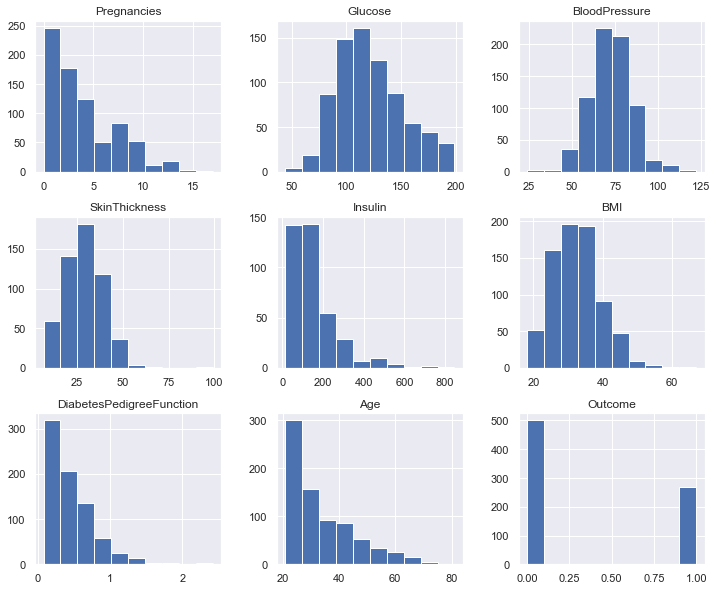

In [8]:
diabetes_data.hist(figsize=(12,10));

#### Replace the zeros with mean and median values.

In [9]:
diabetes_data['Glucose'].fillna(diabetes_data['Glucose'].mean(), inplace = True)
diabetes_data['BloodPressure'].fillna(diabetes_data['BloodPressure'].mean(), inplace = True)
diabetes_data['SkinThickness'].fillna(diabetes_data['SkinThickness'].median(), inplace = True)
diabetes_data['Insulin'].fillna(diabetes_data['Insulin'].median(), inplace = True)
diabetes_data['BMI'].fillna(diabetes_data['BMI'].median(), inplace = True)

**<font color='teal'> Plot histograms of each column after replacing nan. </font>**

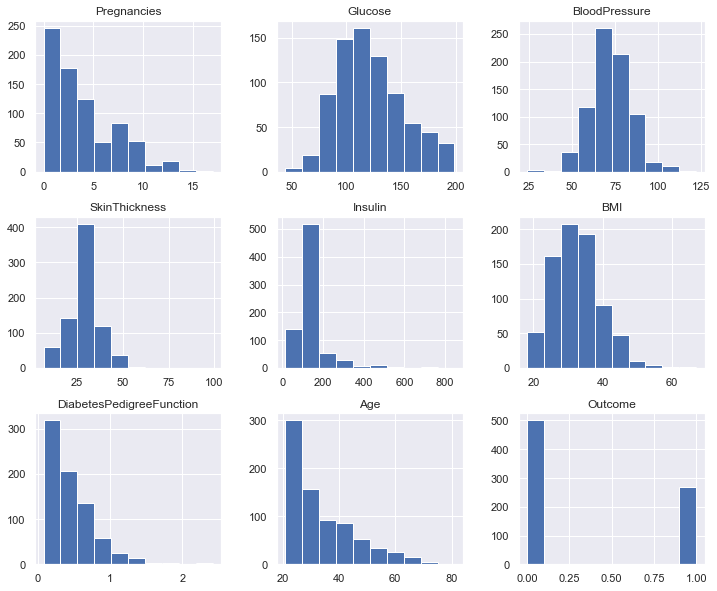

In [10]:
diabetes_data.hist(figsize=(12,10));

#### Plot the correlation matrix heatmap

Correlation between various features


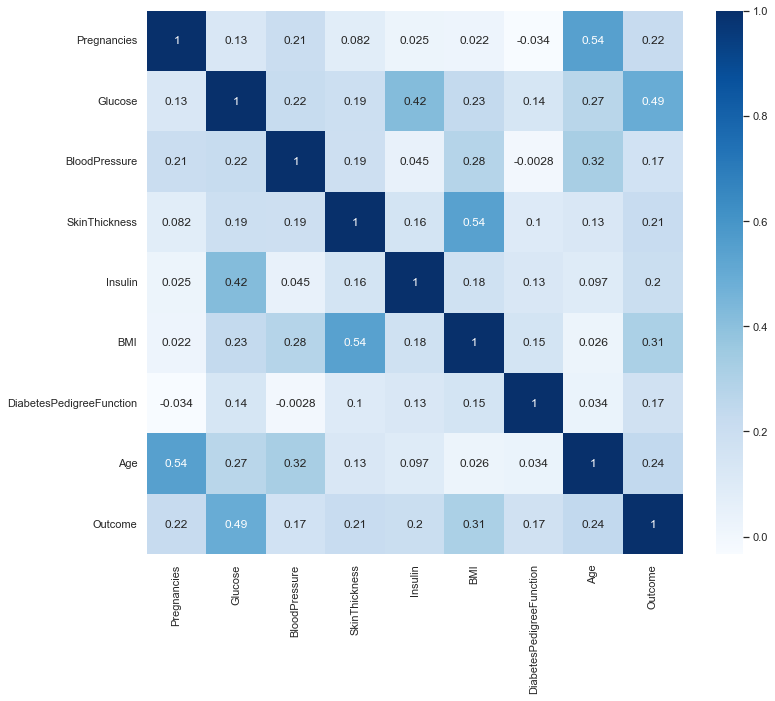

In [11]:
plt.figure(figsize=(12,10))
print('Correlation between various features')
p=sns.heatmap(diabetes_data.corr(), annot=True,cmap ='Blues')

**<font color='teal'> Define the `y` variable as the `Outcome` column.</font>**

In [12]:
y = diabetes_data['Outcome']
X = diabetes_data.drop('Outcome',axis=1)

**<font color='teal'> Create a 70/30 train and test split. </font>**

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

**<font color='teal'> Using Sklearn, standarize the magnitude of the features by scaling the values. </font>**

Note: Don't forget to fit() your scaler on X_train and then use that fitted scaler to transform() X_test. This is to avoid data leakage while you standardize your data.

In [14]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

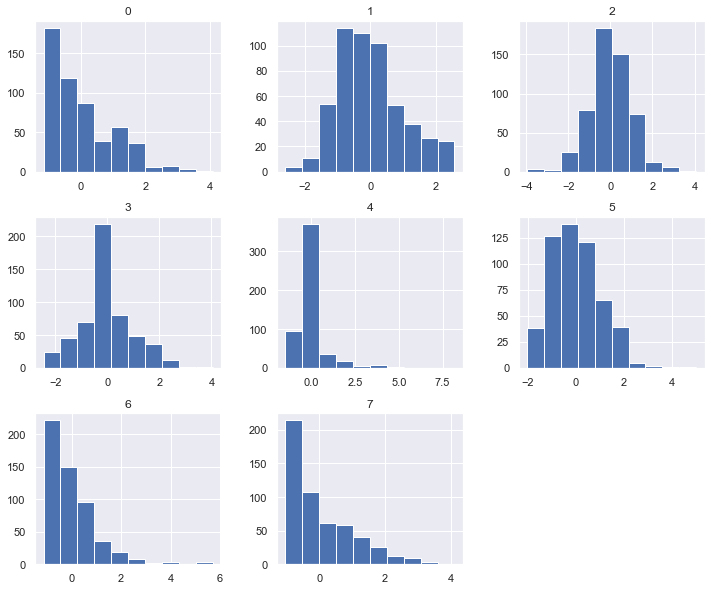

In [15]:
pd.DataFrame(X_train).hist(figsize=(12,10));

#### Using a range of neighbor values of 1-10, apply the KNearestNeighbor classifier to classify the the data.

In [16]:
test_scores = []
train_scores = []

for i in range(1,10):

    knn = KNeighborsClassifier(i)
    knn.fit(X_train,y_train)
    
    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))

**<font color='teal'> Print the train and test scores for each iteration.</font>**

In [17]:
results = pd.DataFrame(dict(neighbors = np.arange(1, 9+1),train_scores = train_scores,test_scores=test_scores)).set_index('neighbors')
results

,train_scores,test_scores
neighbors,,
1,1.000000,0.666667
2,0.851024,0.670996
3,0.854749,0.670996
4,0.841713,0.692641
5,0.839851,0.701299
6,0.823091,0.683983
7,0.834264,0.731602
8,0.821229,0.735931
9,0.826816,0.731602


**<font color='teal'> Identify the number of neighbors that resulted in the max score in the training dataset. </font>**

In [18]:
results['train_scores'].idxmax()

1

**<font color='teal'> Identify the number of neighbors that resulted in the max score in the testing dataset. </font>**

In [19]:
results['test_scores'].idxmax()

8

Plot the train and test model performance by number of neighbors.

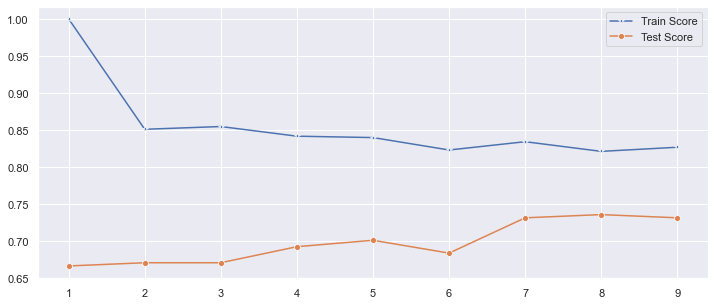

In [20]:
plt.figure(figsize=(12,5))
p = sns.lineplot(x=range(1,10),y=train_scores,marker='*',label='Train Score')
p = sns.lineplot(x=range(1,10),y=test_scores,marker='o',label='Test Score')

**<font color='teal'> Fit and score the best number of neighbors based on the plot. </font>**

In [21]:
i = results['test_scores'].idxmax()
knn = KNeighborsClassifier(i)
knn.fit(X_train,y_train)
    
train_score = knn.score(X_train,y_train)
test_score = knn.score(X_test,y_test)

In [22]:
y_pred = knn.predict(X_test)
pl = confusion_matrix(y_test,y_pred)

**<font color='teal'> Plot the confusion matrix for the model fit above. </font>**

Confusion matrix
[[126  25]
 [ 36  44]]


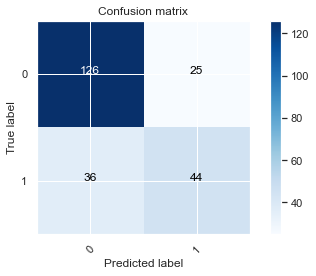

In [23]:
plot_confusion_matrix(pl, classes=['0','1'], title='Confusion matrix')

**<font color='teal'> Print the classification report </font>**

In [24]:
report = classification_report(y_test, y_pred, digits=2)
print(report)

              precision    recall  f1-score   support

           0       0.78      0.83      0.81       151
           1       0.64      0.55      0.59        80

    accuracy                           0.74       231
   macro avg       0.71      0.69      0.70       231
weighted avg       0.73      0.74      0.73       231



#### In the case of the K nearest neighbors algorithm, the K parameter is one of the most important parameters affecting the model performance.  The model performance isn't horrible, but what if we didn't consider a wide enough range of values in our neighbors for the KNN? An alternative to fitting a loop of models is to use a grid search to identify the proper number. It is common practice to use a grid search method for all adjustable parameters in any type of machine learning algorithm. First, you define the grid — aka the range of values — to test in the parameter being optimized, and then compare the model outcome performance based on the different values in the grid.

#### Run the code in the next cell to see how to implement the grid search method for identifying the best parameter value for the n_neighbors parameter. Notice the param_grid is the range value to test and we apply cross validation with five folds to score each possible value of n_neighbors.

In [25]:
param_grid = {'n_neighbors':np.arange(1,50)}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X,y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

#### Print the best score and best parameter for n_neighbors.

In [26]:
print("Best Score: " + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))

Best Score: 0.7526440879382056
Best Parameters: {'n_neighbors': 31}


Here you can see that the ideal number of n_neighbors for this model is 14 based on the grid search performed.

<< CB >> um, it looks like 31 for me.  Perhaps different splitting of hold-out set in 5-fold cross validation.  I also note that pre-filled code applies this search on all data, not just X_train, y_train.

**<font color='teal'> Now, following the KNN example, apply this grid search method to find the optimal number of estimators in a Randon Forest model.
</font>**

In [29]:
param_grid = {'n_estimators':[25,50,100,200,400,800,1600]}

rfc = RandomForestClassifier(random_state=1)
rfc_cv = GridSearchCV(rfc, param_grid=param_grid, cv=5, n_jobs=-1)
rfc_cv.fit(X,y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'n_estimators': [25, 50, 100, 200, 400, 800, 1600]})

In [30]:
print("Best Score: " + str(rfc_cv.best_score_))
print("Best Parameters: " + str(rfc_cv.best_params_))

Best Score: 0.7656905186316951
Best Parameters: {'n_estimators': 100}
